[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1hGfRFWo_UwnEIQJvrBw6XIuHjm0ovBY3#scrollTo=8KNEuM_G83vi) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://colab.research.google.com/drive/1hGfRFWo_UwnEIQJvrBw6XIuHjm0ovBY3#scrollTo=8KNEuM_G83vi)

# Using Third Party Vector Databases with Orq.ai

This quick guide demonstrates how to connect and use third party vector databases like Pinecone with your Orq pipelines for custom retrieval use cases.

Before you begin, make sure you have an Orq account. If you do not have one yet, sign up here. If you prefer to skip setup and start experimenting right away, we have prepared a Google Colab file that you can copy and run. Just drop in your API key and Pinecone credentials and you are ready to go.

Note: Orq also includes a fully hosted knowledge base powered by Pinecone. This is a great option if you want to enable retrieval without managing infrastructure. This guide is for users who prefer to connect their own Pinecone project or another third party vector database.

### Step 1: Install Dependencies

Pinecone provides [SDKs](https://docs.pinecone.io/reference/pinecone-sdks) in multiple languages.

Start by installing the required packages. You will need the Orq SDK along with the Pinecone client and supporting tools.

In [ ]:
!pip install -qU \
    pinecone==6.0.2 \
    pinecone-notebooks \
    orq-ai-sdk \
    requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.2/185.2 kB 14.2 MB/s eta 0:00:00


#### Get an API key

You need an API key to make calls to your Pinecone project.

Use the widget below to generate a key. If you don't have a Pinecone account, the widget will sign you up for the free Starter plan.

In [ ]:
import os

if not os.environ.get("PINECONE_API_KEY"):
    from pinecone_notebooks.colab import Authenticate
    Authenticate()

In [ ]:
%env ORQ_API_KEY=<YOUR_ORQ_API_KEY>

env: ORQ_API_KEY=<YOUR_ORQ_API_KEY>


## Step 2: Initialize Orq and Pinecone

Before we can create or query the vectorDB, we need to initialize both the Orq client and the Pinecone client.

Use the generated Pinecone API key to intialize a Pinecone client:

In [ ]:
# Import the Pinecone library
from pinecone import Pinecone

# Initialize a Pinecone client with your API key
api_key = os.environ.get("PINECONE_API_KEY")
pc = Pinecone(api_key=api_key)

### Initialize Orq

In [ ]:
# Initialize the Orq client
import os
from orq_ai_sdk import Orq

client = Orq(
  api_key=os.environ["ORQ_API_KEY"],
)

## Step 3: Create an index

In Pinecone, there are two types of indexes for storing vector data: [Dense indexes](https://docs.pinecone.io/guides/indexes/understanding-indexes#dense-indexes) store dense vectors for semantic search, and [sparse indexes](https://docs.pinecone.io/guides/indexes/understanding-indexes#sparse-indexes) store sparse vectors for lexical/keyword search.

For this quickstart, create a dense index that is integrated with an [embedding model hosted by Pinecone](https://docs.pinecone.io/guides/inference/understanding-inference#embedding-models). With integrated models, you upsert and search with text and have Pinecone generate vectors automatically.

**Note:** If you prefer to use external embedding models, see [Bring your own vectors](https://docs.pinecone.io/guides/indexes/understanding-indexes#bring-your-own-vectors).

In [ ]:
# Create a dense index with integrated embedding

index_name = "dense-index"

if not pc.has_index(name=index_name):
    pc.create_index_for_model(
        name=index_name,
        cloud="aws",
        region="us-east-1",
        embed={
            "model":"llama-text-embed-v2",
            "field_map":{"text": "chunk_text"}
        }
    )


## Step 4: Upsert records

Prepare a sample dataset of factual statements from different domains like history, physics, technology, and music. Format the data as records with an ID, text, and category. These objects are expected to contain a `chunk_text` key because of the `field_map` we specified when creating the index above.

Other fields which are not mapped in the field mapping, like `category`, will become metadata on the upserted records.

In [ ]:
# Define your dataset
records = [
    { "_id": "rec1", "chunk_text": "The Eiffel Tower was completed in 1889 and stands in Paris, France.", "category": "history" },
    { "_id": "rec2", "chunk_text": "Photosynthesis allows plants to convert sunlight into energy.", "category": "science" },
    { "_id": "rec3", "chunk_text": "Albert Einstein developed the theory of relativity.", "category": "science" },
    { "_id": "rec4", "chunk_text": "The mitochondrion is often called the powerhouse of the cell.", "category": "biology" },
    { "_id": "rec5", "chunk_text": "Shakespeare wrote many famous plays, including Hamlet and Macbeth.", "category": "literature" },
    { "_id": "rec6", "chunk_text": "Water boils at 100°C under standard atmospheric pressure.", "category": "physics" },
    { "_id": "rec7", "chunk_text": "The Great Wall of China was built to protect against invasions.", "category": "history" },
    { "_id": "rec8", "chunk_text": "Honey never spoils due to its low moisture content and acidity.", "category": "food science" },
    { "_id": "rec9", "chunk_text": "The speed of light in a vacuum is approximately 299,792 km/s.", "category": "physics" },
    { "_id": "rec10", "chunk_text": "Newton’s laws describe the motion of objects.", "category": "physics" },
    { "_id": "rec11", "chunk_text": "The human brain has approximately 86 billion neurons.", "category": "biology" },
    { "_id": "rec12", "chunk_text": "The Amazon Rainforest is one of the most biodiverse places on Earth.", "category": "geography" },
    { "_id": "rec13", "chunk_text": "Black holes have gravitational fields so strong that not even light can escape.", "category": "astronomy" },
    { "_id": "rec14", "chunk_text": "The periodic table organizes elements based on their atomic number.", "category": "chemistry" },
    { "_id": "rec15", "chunk_text": "Leonardo da Vinci painted the Mona Lisa.", "category": "art" },
    { "_id": "rec16", "chunk_text": "The internet revolutionized communication and information sharing.", "category": "technology" },
    { "_id": "rec17", "chunk_text": "The Pyramids of Giza are among the Seven Wonders of the Ancient World.", "category": "history" },
    { "_id": "rec18", "chunk_text": "Dogs have an incredible sense of smell, much stronger than humans.", "category": "biology" },
    { "_id": "rec19", "chunk_text": "The Pacific Ocean is the largest and deepest ocean on Earth.", "category": "geography" },
    { "_id": "rec20", "chunk_text": "Chess is a strategic game that originated in India.", "category": "games" },
    { "_id": "rec21", "chunk_text": "The Statue of Liberty was a gift from France to the United States.", "category": "history" },
    { "_id": "rec22", "chunk_text": "Coffee contains caffeine, a natural stimulant.", "category": "food science" },
    { "_id": "rec23", "chunk_text": "Thomas Edison invented the practical electric light bulb.", "category": "inventions" },
    { "_id": "rec24", "chunk_text": "The moon influences ocean tides due to gravitational pull.", "category": "astronomy" },
    { "_id": "rec25", "chunk_text": "DNA carries genetic information for all living organisms.", "category": "biology" },
    { "_id": "rec26", "chunk_text": "Rome was once the center of a vast empire.", "category": "history" },
    { "_id": "rec27", "chunk_text": "The Wright brothers pioneered human flight in 1903.", "category": "inventions" },
    { "_id": "rec28", "chunk_text": "Bananas are a good source of potassium.", "category": "nutrition" },
    { "_id": "rec29", "chunk_text": "The stock market fluctuates based on supply and demand.", "category": "economics" },
    { "_id": "rec30", "chunk_text": "A compass needle points toward the magnetic north pole.", "category": "navigation" },
    { "_id": "rec31", "chunk_text": "The universe is expanding, according to the Big Bang theory.", "category": "astronomy" },
    { "_id": "rec32", "chunk_text": "Elephants have excellent memory and strong social bonds.", "category": "biology" },
    { "_id": "rec33", "chunk_text": "The violin is a string instrument commonly used in orchestras.", "category": "music" },
    { "_id": "rec34", "chunk_text": "The heart pumps blood throughout the human body.", "category": "biology" },
    { "_id": "rec35", "chunk_text": "Ice cream melts when exposed to heat.", "category": "food science" },
    { "_id": "rec36", "chunk_text": "Solar panels convert sunlight into electricity.", "category": "technology" },
    { "_id": "rec37", "chunk_text": "The French Revolution began in 1789.", "category": "history" },
    { "_id": "rec38", "chunk_text": "The Taj Mahal is a mausoleum built by Emperor Shah Jahan.", "category": "history" },
    { "_id": "rec39", "chunk_text": "Rainbows are caused by light refracting through water droplets.", "category": "physics" },
    { "_id": "rec40", "chunk_text": "Mount Everest is the tallest mountain in the world.", "category": "geography" },
    { "_id": "rec41", "chunk_text": "Octopuses are highly intelligent marine creatures.", "category": "biology" },
    { "_id": "rec42", "chunk_text": "The speed of sound is around 343 meters per second in air.", "category": "physics" },
    { "_id": "rec43", "chunk_text": "Gravity keeps planets in orbit around the sun.", "category": "astronomy" },
    { "_id": "rec44", "chunk_text": "The Mediterranean diet is considered one of the healthiest in the world.", "category": "nutrition" },
    { "_id": "rec45", "chunk_text": "A haiku is a traditional Japanese poem with a 5-7-5 syllable structure.", "category": "literature" },
    { "_id": "rec46", "chunk_text": "The human body is made up of about 60% water.", "category": "biology" },
    { "_id": "rec47", "chunk_text": "The Industrial Revolution transformed manufacturing and transportation.", "category": "history" },
    { "_id": "rec48", "chunk_text": "Vincent van Gogh painted Starry Night.", "category": "art" },
    { "_id": "rec49", "chunk_text": "Airplanes fly due to the principles of lift and aerodynamics.", "category": "physics" },
    { "_id": "rec50", "chunk_text": "Renewable energy sources include wind, solar, and hydroelectric power.", "category": "energy" }
]

[Upsert](https://docs.pinecone.io/guides/data/upsert-data) the sample dataset into a new namespace in your index.

Because your index is integrated with an embedding model, you provide the textual statements and Pinecone converts them to dense vectors automatically.

In [ ]:
# Get an Index client for the index we created
dense_index = pc.Index(name=index_name)

# Upsert records into a namespace
dense_index.upsert_records(
    namespace="example-namespace-2",
    records=records
)

## Step 5: Check index stats

Pinecone is eventually consistent, so there can be a slight delay before new or changed records are visible to queries. You can [view index stats](https://docs.pinecone.io/guides/data/check-data-freshness#verify-record-counts) to check if the current vector count matches the number of vectors you upserted (50):

In [ ]:
import time

# Wait for the upserted vectors to be indexed
time.sleep(10)

# View stats for the index
stats = dense_index.describe_index_stats()
stats

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'example-namespace': {'vector_count': 50},
                'example-namespace-2': {'vector_count': 50}},
 'total_vector_count': 100,
 'vector_type': 'dense'}

## Step 6: Semantic search

[Search the dense index](https://docs.pinecone.io/guides/data/query-data#semantic-search) for ten records that are most semantically similar to the query, `Famous historical structures and monuments`.

Again, because your index is integrated with an embedding model, you provide the query as text and Pinecone converts the text to a dense vector automatically.

In [ ]:
def print_results(search_results):
    for hit in search_results['result']['hits']:
        print(f"id: {hit['_id']:<5} | score: {round(hit['_score'], 3):<5} | category: {hit['fields']['category']:<10} | text: {hit['fields']['chunk_text']:<50}")


In [ ]:
from pinecone import SearchQuery, SearchRerank

# Define the query
query = "Famous historical structures and monuments"

# Search the dense index
results = dense_index.search(
    namespace="example-namespace",
    query=SearchQuery(
        top_k=10,
        inputs={'text': query}
    )
)

print_results(results)

id: rec17 | score: 0.26  | category: history    | text: The Pyramids of Giza are among the Seven Wonders of the Ancient World.
id: rec38 | score: 0.183 | category: history    | text: The Taj Mahal is a mausoleum built by Emperor Shah Jahan.
id: rec5  | score: 0.179 | category: literature | text: Shakespeare wrote many famous plays, including Hamlet and Macbeth.
id: rec15 | score: 0.105 | category: art        | text: Leonardo da Vinci painted the Mona Lisa.          
id: rec50 | score: 0.094 | category: energy     | text: Renewable energy sources include wind, solar, and hydroelectric power.
id: rec26 | score: 0.086 | category: history    | text: Rome was once the center of a vast empire.        
id: rec1  | score: 0.079 | category: history    | text: The Eiffel Tower was completed in 1889 and stands in Paris, France.
id: rec7  | score: 0.074 | category: history    | text: The Great Wall of China was built to protect against invasions.
id: rec47 | score: 0.072 | category: history    | t

Notice that most of the results are about historical structures and monuments. However, a few unrelated statements are included as well and are ranked high in the list, for example, statements about Shakespeare and renewable energy.

To get a more accurate ranking, search again but this time [rerank the initial results](https://docs.pinecone.io/guides/data/query-data#rerank-results) based on their relevance to the query.

## Step 7: Improve results

Reranking results is one of the most effective ways to improve search accuracy and relevance, but there are many other techniques to consider. For example:

* [Filtering by metadata](https://docs.pinecone.io/guides/data/query-data#filter-by-metadata): When records contain additional metadata, you can limit the search to records matching a filter expression.

* [Hybrid search](https://docs.pinecone.io/guides/data/query-data#hybrid-search): You can add lexical search to capture precise keyword matches (e.g., product SKUs, email addresses, domain-specific terms) in addition to semantic matches.

* [Chunking strategies](https://www.pinecone.io/learn/chunking-strategies/): You can chunk your content in different ways to get better results. Consider factors like the length of the content, the complexity of queries, and how results will be used in your application.

In [ ]:
# Search the dense index and rerank results
reranked_results = dense_index.search(
    namespace="example-namespace",
    query=SearchQuery(
        top_k=10,
        inputs={'text': query}
    ),
    rerank=SearchRerank(
        model="bge-reranker-v2-m3",
        top_n=10,
        rank_fields=["chunk_text"]
    )
)

print_results(reranked_results)

id: rec1  | score: 0.107 | category: history    | text: The Eiffel Tower was completed in 1889 and stands in Paris, France.
id: rec38 | score: 0.065 | category: history    | text: The Taj Mahal is a mausoleum built by Emperor Shah Jahan.
id: rec7  | score: 0.062 | category: history    | text: The Great Wall of China was built to protect against invasions.
id: rec21 | score: 0.019 | category: history    | text: The Statue of Liberty was a gift from France to the United States.
id: rec17 | score: 0.015 | category: history    | text: The Pyramids of Giza are among the Seven Wonders of the Ancient World.
id: rec26 | score: 0.011 | category: history    | text: Rome was once the center of a vast empire.        
id: rec15 | score: 0.008 | category: art        | text: Leonardo da Vinci painted the Mona Lisa.          
id: rec5  | score: 0.0   | category: literature | text: Shakespeare wrote many famous plays, including Hamlet and Macbeth.
id: rec47 | score: 0.0   | category: history    | text:

Notice that all of the most relevant results about historical structures and monuments are now ranked highest.

## Step 8: How to Pass the Reranked Results to Orq.ai
Once you have retrieved and optionally reranked results from Pinecone, the final step is to pass them into your Orq deployment for generation.

The key is to store the original user query in a variable.
This is the input that will be sent to Orq under the `query` field.
The cleaned and reranked chunks from Pinecone should be passed under the `retrievals` field, allowing Orq to use them as contextual support for generation.

This is what the system and user prompt look like configured in Orq:

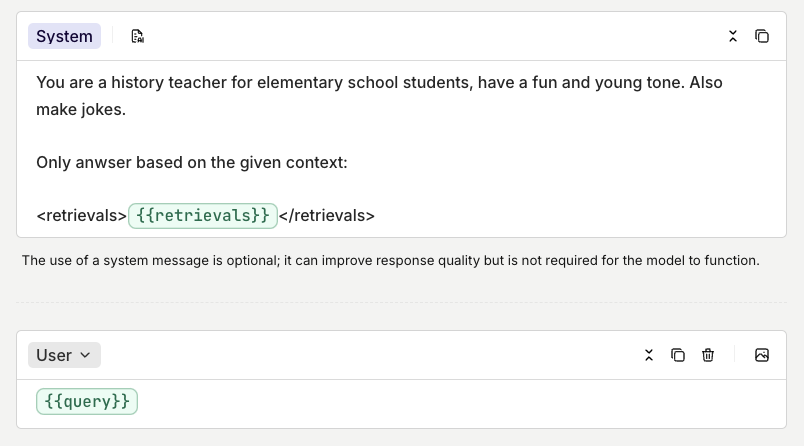



In [ ]:
chunk_texts = [hit['fields']['chunk_text'] for hit in reranked_results['result']['hits']]


In [ ]:
retrievals = "\n".join(chunk_texts)  # or ". ".join(...) if you want sentence-style joining

In [ ]:
generation = client.deployments.invoke(
  key="pinecone-test",
  context={
    "environments": []
  },
  inputs={
    "query": query,
    "retrievals": retrievals
  },
  metadata={
    "custom-field-name": "custom-metadata-value"
  }
)

print(generation.choices[0].message.content)

# World-Famous Monuments: A Mini History Tour! 🌍

Hello, junior historians! Today we're going to explore some AMAZING structures that people built a long, LONG time ago! (Like, even before TikTok existed! Can you believe it? 😱)

## The Eiffel Tower 🗼
This super tall tower stands in Paris, France and was completed in 1889! It was like the world's biggest selfie stick of its time! "Bonjour, everyone! Just hanging out 1,063 feet in the air!"

## The Taj Mahal 💕
This beautiful building is actually a super fancy tomb! Emperor Shah Jahan built it as a gigantic "I love you" card for his wife. Talk about relationship goals! Most of us just get flowers!

## The Great Wall of China 🧱
This MASSIVE wall was built to keep invaders out of China. It's like when your little brother puts a "KEEP OUT" sign on his door, except it's 13,000 miles long! That's one serious "Do Not Disturb" sign!

## The Statue of Liberty 🗽
This green lady was a present from France to the United States! Imagine getting this f

## Next Steps

Congratulations! You have successfully connected Pinecone to an Orq deployment and passed external retrieval results into a live workflow.

This pattern works the same way with any external vector database. You retrieve the most relevant chunks, pass them as context, and let Orq handle generation and orchestration.

To improve and scale this setup inside Orq:

* Use **RAGAS inside Orq** to evaluate the quality of retrieved chunks before they reach the model. This helps you understand if the retrieval step is actually helping the model generate better answers.

* Connect other vector databases such as Qdrant or Weaviate using the same interface

* Experiment with prompt variations and test their impact using Orq's built-in evaluation tooling

* Version, deploy, and monitor your pipelines using Orq’s production features

If you want to get started even faster, you can skip external setup entirely by using **Orq’s fully hosted vector database**, powered by Pinecone. It handles embedding, indexing, and retrieval out of the box, so you can focus on designing great applications.

For more examples and integrations, visit the [Orq documentation.](https://docs.orq.ai/docs/introduction)